In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # <- this line is the fix

from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# === Custom COCO Dataset for Your Custom Classes ===
class CustomCocoDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        if self._transforms:
            img = self._transforms(img)

        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for obj in target:
            x, y, w, h = obj["bbox"]
            if w <= 0 or h <= 0:
                continue
            x_min, y_min, x_max, y_max = x, y, x + w, y + h
            if x_max > x_min and y_max > y_min:
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(obj["category_id"])
                areas.append(obj["area"])
                iscrowd.append(obj.get("iscrowd", 0))

        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]
            labels = [0]
            areas = [1.0]
            iscrowd = [0]

        new_target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx]),
            "area": torch.tensor(areas, dtype=torch.float32),
            "iscrowd": torch.tensor(iscrowd, dtype=torch.int64)
        }

        return img, new_target

# === Paths ===
image_dir = '/nfsshare/sanjay/retina_net/train1000/images/'
annotation_file = "/nfsshare/sanjay/retina_net/coco_annotations1000.json"
# === Dataset and Dataloader ===
dataset = CustomCocoDataset(image_dir, annotation_file, transforms=ToTensor())
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# === Model Setup ===
num_classes = 5  # 4 classes + background
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Optimizer ===
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# === Training ===
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}]")
    model.train()
    total_loss = 0.0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f}")
    torch.save(model.state_dict(), "fasterrcnn_custom_1000.pth")

# === Save the Trained Model ===
torch.save(model.state_dict(), "fasterrcnn_custom_1000.pth")
print("Model saved as 'fasterrcnn_custom_1000.pth'")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch [1]
Epoch [1/5] - Loss: 58.9172
Epoch [2]
Epoch [2/5] - Loss: 27.8191
Epoch [3]
Epoch [3/5] - Loss: 23.0240
Epoch [4]
Epoch [4/5] - Loss: 19.3784
Epoch [5]
Epoch [5/5] - Loss: 17.3722
Model saved as 'fasterrcnn_custom_1000.pth'


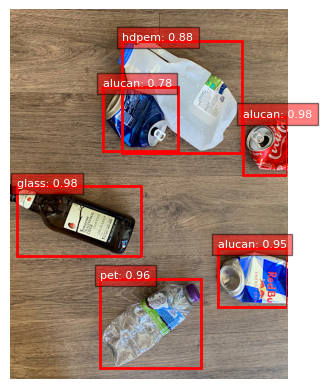

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# === Configuration ===
model_path = "/nfsshare/sanjay/fasterrcnn_custom.pth"
image_path = "/nfsshare/sanjay/retina_net/retinanet_test/mix21.jpg"
num_classes = 5  # 4 custom classes + background
class_names = ["background", "alucan", "glass", "hdpem", "pet"]  # Modify if needed
score_threshold = 0.5

# === Load Model ===
def load_model(model_path, num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()
    return model

# === Predict and Visualize ===
def predict_and_show(model, image_path, class_names=None, threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)

    boxes = outputs[0]["boxes"].cpu()
    scores = outputs[0]["scores"].cpu()
    labels = outputs[0]["labels"].cpu()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            label_name = class_names[label] if class_names and label < len(class_names) else f"Class {label}"
            ax.text(x_min, y_min, f"{label_name}: {score:.2f}", color='white',
                    fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis("off")
    plt.show()

# === Run It ===
model = load_model(model_path, num_classes)
predict_and_show(model, image_path, class_names, threshold=score_threshold)


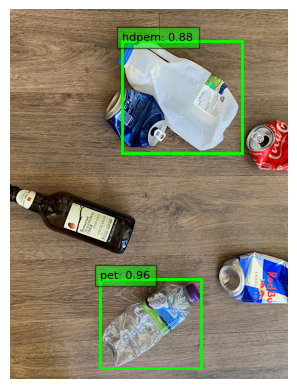

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# === Configuration ===
model_path = "/nfsshare/sanjay/fasterrcnn_custom.pth"
image_path = "/nfsshare/sanjay/retina_net/retinanet_test/mix21.jpg"
num_classes = 5  # 4 custom classes + background
class_names = ["background", "alucan", "glass", "hdpem", "pet"]  # Modify if needed
score_threshold = 0.5
allowed_labels = [3, 4]  # Only show "paper" and "glass"

# === Load Model ===
def load_model(model_path, num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()
    return model

# === Predict and Visualize (Filtered) ===
def predict_and_show_filtered(model, image_path, class_names=None, threshold=0.5, allowed_labels=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)

    boxes = outputs[0]["boxes"].cpu()
    scores = outputs[0]["scores"].cpu()
    labels = outputs[0]["labels"].cpu()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold and (allowed_labels is None or label.item() in allowed_labels):
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(rect)
            label_name = class_names[label] if class_names and label < len(class_names) else f"Class {label}"
            ax.text(x_min, y_min, f"{label_name}: {score:.2f}", color='black',
                    fontsize=8, bbox=dict(facecolor='lime', alpha=0.5))

    plt.axis("off")
    plt.show()

# === Run It ===
model = load_model(model_path, num_classes)
predict_and_show_filtered(model, image_path, class_names, threshold=score_threshold, allowed_labels=allowed_labels)


In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

# === Configuration ===
model_path = "/nfsshare/sanjay/fasterrcnn_custom.pth"
image_dir = "/nfsshare/sanjay/retina_net/retinanet_test/"
output_dir = "/nfsshare/sanjay/retina_net/"
num_classes = 5  # 4 custom classes + background
class_names = ["background", "alucan", "glass", "hdpem", "pet"]
score_threshold = 0.5
allowed_labels = [3, 4]  # Only "hdpem" and "pet"

# Create output folder
os.makedirs(output_dir, exist_ok=True)

# === Load Model ===
def load_model(model_path, num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()
    return model

# === Predict and Save Visualization ===
def predict_and_save(model, image_path, save_path, class_names=None, threshold=0.5, allowed_labels=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)

    boxes = outputs[0]["boxes"].cpu()
    scores = outputs[0]["scores"].cpu()
    labels = outputs[0]["labels"].cpu()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold and (allowed_labels is None or label.item() in allowed_labels):
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(rect)
            label_name = class_names[label] if class_names and label < len(class_names) else f"Class {label}"
            ax.text(x_min, y_min, f"{label_name}: {score:.2f}", color='black',
                    fontsize=8, bbox=dict(facecolor='lime', alpha=0.5))

    plt.axis("off")
    plt.savefig(save_path, bbox_inches="tight")
    plt.close()

# === Run Predictions on All Images ===
model = load_model(model_path, num_classes)

image_extensions = (".jpg", ".jpeg", ".png")
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_extensions)]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    out_path = os.path.join(output_dir, f"pred_{img_file}")
    predict_and_save(model, img_path, out_path, class_names, score_threshold, allowed_labels)
    print(f"Saved: {out_path}")


/SASTRA_GPFS_CLUSTER/apps/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/SASTRA_GPFS_CLUSTER/apps/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Saved: /nfsshare/sanjay/retina_net/pred_mix1.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix10.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix11.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix12.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix13.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix14.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix15.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix16.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix17.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix18.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix19.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix2.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix20.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix21.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix22.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix23.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix24.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix3.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix4.jpg
Saved: /nfsshare/sanjay/retina_net/pred_mix5.jpg
Saved

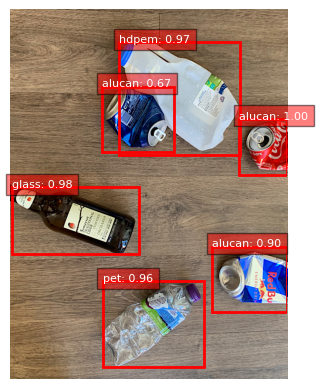

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# === Configuration ===
model_path = "/nfsshare/sanjay/fasterrcnn_custom_1000.pth"
image_path = "/nfsshare/sanjay/retina_net/retinanet_test/mix21.jpg"
num_classes = 5  # 4 custom classes + background
class_names = ["background", "alucan", "glass", "hdpem", "pet"]  # Modify if needed
score_threshold = 0.5

# === Load Model ===
def load_model(model_path, num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()
    return model

# === Predict and Visualize ===
def predict_and_show(model, image_path, class_names=None, threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)

    boxes = outputs[0]["boxes"].cpu()
    scores = outputs[0]["scores"].cpu()
    labels = outputs[0]["labels"].cpu()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            label_name = class_names[label] if class_names and label < len(class_names) else f"Class {label}"
            ax.text(x_min, y_min, f"{label_name}: {score:.2f}", color='white',
                    fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis("off")
    plt.show()

# === Run It ===
model = load_model(model_path, num_classes)
predict_and_show(model, image_path, class_names, threshold=score_threshold)


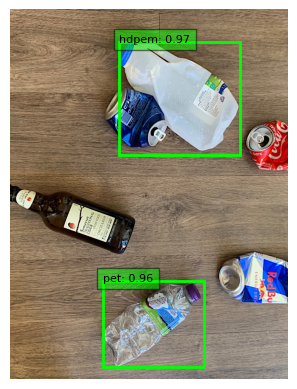

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# === Configuration ===
model_path = "/nfsshare/sanjay/fasterrcnn_custom_1000.pth"
image_path = "/nfsshare/sanjay/retina_net/retinanet_test/mix21.jpg"
num_classes = 5  # 4 custom classes + background
class_names = ["background", "alucan", "glass", "hdpem", "pet"]  # Modify if needed
score_threshold = 0.5
allowed_labels = [3, 4]  # Only show "paper" and "glass"

# === Load Model ===
def load_model(model_path, num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()
    return model

# === Predict and Visualize (Filtered) ===
def predict_and_show_filtered(model, image_path, class_names=None, threshold=0.5, allowed_labels=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)

    boxes = outputs[0]["boxes"].cpu()
    scores = outputs[0]["scores"].cpu()
    labels = outputs[0]["labels"].cpu()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold and (allowed_labels is None or label.item() in allowed_labels):
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(rect)
            label_name = class_names[label] if class_names and label < len(class_names) else f"Class {label}"
            ax.text(x_min, y_min, f"{label_name}: {score:.2f}", color='black',
                    fontsize=8, bbox=dict(facecolor='lime', alpha=0.5))

    plt.axis("off")
    plt.show()

# === Run It ===
model = load_model(model_path, num_classes)
predict_and_show_filtered(model, image_path, class_names, threshold=score_threshold, allowed_labels=allowed_labels)
